<a href="https://colab.research.google.com/github/superpanditas/mobo/blob/main/MOBO_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objetivo: Desarrollar un modelo para pronosticar ventas futuras, utilizando las variables disponibles en el dataset

- Utilizaremos los lags
- dayofweek, dayofyear
- rolling mean

Y evaluaremos usando RMSE pues nos da el error en terminos de la variable a pronostiar, facilitando la interpretación

In [14]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [106]:
df_sales = pd.read_csv('/content/dataset_ventas-2.csv')
df_sales.head()

,ID Producto,ID Tienda,Fecha de Venta,Cantidad Vendida,Precio Unitario,Categoría de Producto,Ubicación de Tienda,Promoción o Descuento,Estacionalidad,Método de Pago,Nivel de Inventario
0,Producto_43,Tienda_2,2023-02-13,81,498.48,Deportes,Zona Este,1,1,Efectivo,10
1,Producto_22,Tienda_1,2023-04-19,25,204.46,Juguetes,Zona Norte,0,1,Crédito,100
2,Producto_27,Tienda_6,2022-05-29,13,253.30,Alimentos,Zona Este,1,0,Crédito,100
3,Producto_6,Tienda_6,2022-08-15,67,134.23,Electrónica,Zona Norte,0,1,Efectivo,50
4,Producto_1,Tienda_5,2023-02-02,21,329.80,Alimentos,Zona Este,1,0,Efectivo,300


In [107]:
features = ['Fecha de Venta', 'ID Producto', 'Cantidad Vendida', 'Promoción o Descuento', 'Estacionalidad']

df_sales['Fecha de Venta'] = pd.to_datetime(df_sales['Fecha de Venta'],
                                            format='%Y-%m-%d')

start_date = df_sales['Fecha de Venta'].min()
end_date = df_sales['Fecha de Venta'].max()
dates = pd.date_range(start=start_date, end=end_date, freq='D')
# stores = df_sales['ID Store'].nunique()
producto = df_sales['ID Producto'].unique()

sheet = pd.MultiIndex.from_product([dates, producto], names=['Fecha de Venta','ID Producto'])
sheet_dates = pd.DataFrame(index=sheet).reset_index()

df_sales_daily = pd.merge(sheet_dates, df_sales[features], on=['Fecha de Venta', 'ID Producto'], how='left')

df_sales_daily.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37676 entries, 0 to 37675
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Fecha de Venta         37676 non-null  datetime64[ns]
 1   ID Producto            37676 non-null  object        
 2   Cantidad Vendida       10000 non-null  float64       
 3   Promoción o Descuento  10000 non-null  float64       
 4   Estacionalidad         10000 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 1.4+ MB


In [108]:
df_sales_daily = df_sales_daily.sort_values(by=['ID Producto', 'Fecha de Venta'])
df_sales_daily['Cantidad Vendida'] = df_sales_daily.groupby('ID Producto')['Cantidad Vendida'].fillna(method='bfill')
df_sales_daily['Cantidad Vendida'] = df_sales_daily.groupby('ID Producto')['Cantidad Vendida'].fillna(method='ffill')
df_sales_daily['Promoción o Descuento'] = df_sales_daily.groupby('ID Producto')['Promoción o Descuento'].fillna(method='bfill')
df_sales_daily['Estacionalidad'] = df_sales_daily.groupby('ID Producto')['Estacionalidad'].fillna(method='bfill')

df_sales_daily.head()

<ipython-input-108-5a342b5f533c>:2: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df_sales_daily['Cantidad Vendida'] = df_sales_daily.groupby('ID Producto')['Cantidad Vendida'].fillna(method='bfill')
<ipython-input-108-5a342b5f533c>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sales_daily['Cantidad Vendida'] = df_sales_daily.groupby('ID Producto')['Cantidad Vendida'].fillna(method='bfill')
<ipython-input-108-5a342b5f533c>:3: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df_sales_daily['Cantidad Vendida'] = df_sales_daily.group

,Fecha de Venta,ID Producto,Cantidad Vendida,Promoción o Descuento,Estacionalidad
4,2022-01-01,Producto_1,2.0,0.0,1.0
59,2022-01-02,Producto_1,2.0,0.0,1.0
110,2022-01-03,Producto_1,2.0,0.0,1.0
161,2022-01-04,Producto_1,2.0,0.0,1.0
214,2022-01-05,Producto_1,2.0,0.0,1.0


In [109]:
df_sales_daily.info()
# from statsmodels.graphics.tsaplots import plot_acf
# plot_acf(df_sales[df_sales['ID Producto'] == 'Producto_1']['Cantidad Vendida'], lags=52)

<class 'pandas.core.frame.DataFrame'>
Index: 37676 entries, 4 to 37671
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Fecha de Venta         37676 non-null  datetime64[ns]
 1   ID Producto            37676 non-null  object        
 2   Cantidad Vendida       37676 non-null  float64       
 3   Promoción o Descuento  37539 non-null  float64       
 4   Estacionalidad         37539 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 1.7+ MB


In [110]:
lags = [30, 31, 32, 33, 34, 35, 363, 364, 365]
for lag_n in lags:
  df_sales_daily[f'lag_{lag_n}'] = df_sales_daily.groupby(['ID Producto'])['Cantidad Vendida'].shift(lag_n)


In [111]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_sales_daily['ID encoded'] = le.fit_transform(df_sales_daily['ID Producto'])
df_sales_daily.head()

,Fecha de Venta,ID Producto,Cantidad Vendida,Promoción o Descuento,Estacionalidad,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_363,lag_364,lag_365,ID encoded
4,2022-01-01,Producto_1,2.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
59,2022-01-02,Producto_1,2.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
110,2022-01-03,Producto_1,2.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
161,2022-01-04,Producto_1,2.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
214,2022-01-05,Producto_1,2.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [112]:
df_sales_daily = df_sales_daily.sort_values('Fecha de Venta')
data = df_sales_daily.set_index(['Fecha de Venta', 'ID Producto'])

FEATURE = ['ID encoded','lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_363', 'lag_364', 'lag_365']
TARGET = ['Cantidad Vendida']

data_train = data['2023-06-01':'2023-06-30']
data_test = data['2023-12-01':'2023-12-31']

x_train, y_train = data_train[FEATURE], data_train[TARGET]
x_test, y_test = data_test[FEATURE], data_test[TARGET]

param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'lambda': [0, 1],
    'alpha': [0, 1]
}

random_search = RandomizedSearchCV(estimator=xgb.XGBRegressor(),
                                   param_distributions=param_dist,
                                   n_iter=50,
                                   cv=3,
                                   scoring='neg_mean_squared_error',
                                   random_state=5)

random_search.fit(x_train, y_train)
print("Best Parameters: ", random_search.best_params_)


Best Parameters:  {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 10, 'max_depth': 4, 'learning_rate': 0.01, 'lambda': 1, 'gamma': 0.2, 'colsample_bytree': 0.9, 'alpha': 0}


In [113]:
# best parameters
best_params = random_search.best_params_
# best model
model_best = xgb.XGBRegressor(**best_params)
# train model
model_best.fit(x_train, y_train)
# forecasting ...
y_pred = model_best.predict(x_test)

In [114]:
import numpy as np
print("Best Model MSE: ", mean_squared_error(y_test, y_pred))
print("Best Model RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Best Model MSE:  848.9142289257803
Best Model RMSE:  29.136132703668487


In [115]:
feature_importances = model_best.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_importances
})

importance_df.sort_values('Importance', ascending=False).head(10)

,Feature,Importance
0,ID encoded,0.127344
8,lag_364,0.116623
1,lag_30,0.103846
4,lag_33,0.102742
2,lag_31,0.101083
9,lag_365,0.093922
3,lag_32,0.093128
5,lag_34,0.090948
7,lag_363,0.089011
6,lag_35,0.081353


<ipython-input-117-e23f31e60fc0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['pred'] = y_pred
<ipython-input-117-e23f31e60fc0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['pred'] = data_test['pred'].round(0)


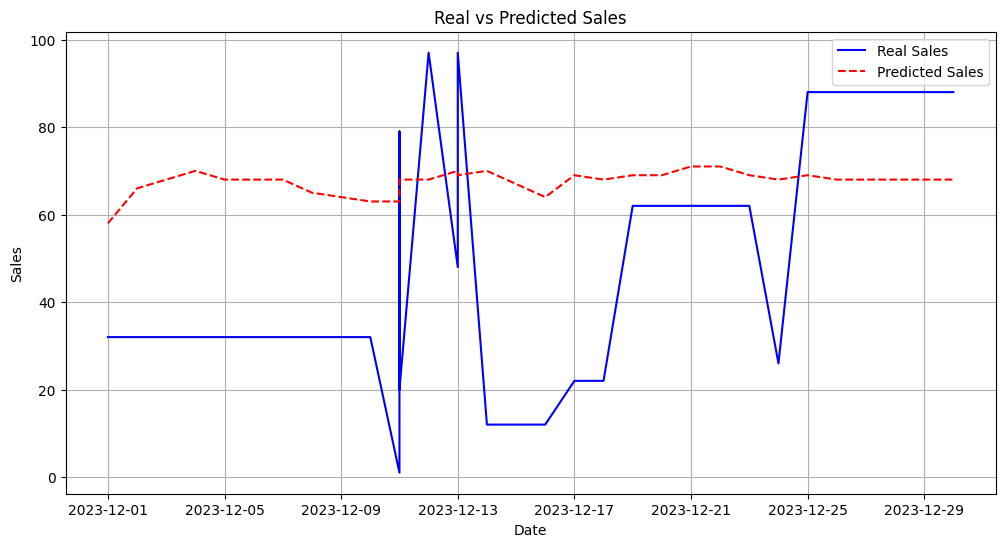

In [117]:
data_test['pred'] = y_pred
data_test['pred'] = data_test['pred'].round(0)

productos_pred = data_test.reset_index()
productos_pred = productos_pred[['Fecha de Venta', 'ID Producto', 'Cantidad Vendida', 'pred']]

productos_pred_flt = productos_pred[productos_pred['ID Producto'] == 'Producto_1']

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(productos_pred_flt['Fecha de Venta'], productos_pred_flt['Cantidad Vendida'], label='Real Sales', color='blue')
plt.plot(productos_pred_flt['Fecha de Venta'], productos_pred_flt['pred'], label='Predicted Sales', color='red', linestyle='--')

plt.title('Real vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


In [127]:
productos_pred_agg = productos_pred.groupby(['ID Producto']).agg({
    'Cantidad Vendida':'sum',
    'pred':'sum'
}).reset_index()

In [129]:
productos_pred_agg['diff'] = productos_pred_agg['pred'] - productos_pred_agg['Cantidad Vendida']
productos_pred_agg.sort_values('diff')

,ID Producto,Cantidad Vendida,pred,diff
33,Producto_4,2526.0,1639.0,-887.0
10,Producto_19,2188.0,1606.0,-582.0
7,Producto_16,2202.0,1674.0,-528.0
5,Producto_14,2096.0,1647.0,-449.0
22,Producto_3,2055.0,1610.0,-445.0
14,Producto_22,2017.0,1605.0,-412.0
47,Producto_7,2213.0,1804.0,-409.0
49,Producto_9,2098.0,1710.0,-388.0
46,Producto_6,2132.0,1757.0,-375.0
36,Producto_42,1978.0,1635.0,-343.0
